In [1]:
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    print(os.path.join(dirname))

/kaggle/input
/kaggle/input/siim-isic-melanoma-classification
/kaggle/input/siim-isic-melanoma-classification/train
/kaggle/input/siim-isic-melanoma-classification/tfrecords
/kaggle/input/siim-isic-melanoma-classification/jpeg
/kaggle/input/siim-isic-melanoma-classification/jpeg/train
/kaggle/input/siim-isic-melanoma-classification/jpeg/test
/kaggle/input/siim-isic-melanoma-classification/test


In [2]:
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly
import plotly.graph_objects as go
import cv2
import tensorflow as tf
from kaggle_datasets import KaggleDatasets
from functools import partial
import sklearn
from tqdm import tqdm_notebook as tqdm
import gc
%matplotlib inline

In [3]:
try:
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.experimental.TPUStrategy(tpu)
except:
    strategy = tf.distribute.get_strategy()

In [4]:
print('Device:', tpu.master())
print('Number of replicas:', strategy.num_replicas_in_sync)
print("Version of Tensorflow used : ", tf.__version__)

Device: grpc://10.0.0.2:8470
Number of replicas: 8
Version of Tensorflow used :  2.2.0


In [5]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
GCS_PATH = KaggleDatasets().get_gcs_path()
BATCH_SIZE = 16 * strategy.num_replicas_in_sync
IMAGE_SIZE = [1024, 1024]
SHAPE = [256, 256]

In [6]:
print("Batch Size = ", BATCH_SIZE)
print("GCS Path = ", GCS_PATH)

Batch Size =  128
GCS Path =  gs://kds-0239565729562a730c95deb52d5a97593f6f7b73d0d8125d1ae74f7e


In [7]:
train = pd.DataFrame(pd.read_csv("../input/siim-isic-melanoma-classification/train.csv"))
train.head()

,image_name,patient_id,sex,age_approx,anatom_site_general_challenge,diagnosis,benign_malignant,target
0,ISIC_2637011,IP_7279968,male,45.0,head/neck,unknown,benign,0
1,ISIC_0015719,IP_3075186,female,45.0,upper extremity,unknown,benign,0
2,ISIC_0052212,IP_2842074,female,50.0,lower extremity,nevus,benign,0
3,ISIC_0068279,IP_6890425,female,45.0,head/neck,unknown,benign,0
4,ISIC_0074268,IP_8723313,female,55.0,upper extremity,unknown,benign,0


In [8]:
test = pd.DataFrame(pd.read_csv("../input/siim-isic-melanoma-classification/test.csv"))
test.head()

,image_name,patient_id,sex,age_approx,anatom_site_general_challenge
0,ISIC_0052060,IP_3579794,male,70.0,NaN
1,ISIC_0052349,IP_7782715,male,40.0,lower extremity
2,ISIC_0058510,IP_7960270,female,55.0,torso
3,ISIC_0073313,IP_6375035,female,50.0,torso
4,ISIC_0073502,IP_0589375,female,45.0,lower extremity


In [9]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 33126 entries, 0 to 33125
Data columns (total 8 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   image_name                     33126 non-null  object 
 1   patient_id                     33126 non-null  object 
 2   sex                            33061 non-null  object 
 3   age_approx                     33058 non-null  float64
 4   anatom_site_general_challenge  32599 non-null  object 
 5   diagnosis                      33126 non-null  object 
 6   benign_malignant               33126 non-null  object 
 7   target                         33126 non-null  int64  
dtypes: float64(1), int64(1), object(6)
memory usage: 2.0+ MB


In [10]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10982 entries, 0 to 10981
Data columns (total 5 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   image_name                     10982 non-null  object 
 1   patient_id                     10982 non-null  object 
 2   sex                            10982 non-null  object 
 3   age_approx                     10982 non-null  float64
 4   anatom_site_general_challenge  10631 non-null  object 
dtypes: float64(1), object(4)
memory usage: 429.1+ KB


In [11]:
train_dir = "/kaggle/input/siim-isic-melanoma-classification/jpeg/train/"

In [12]:
image_names = train["image_name"].values + ".jpg"
random_images = [np.random.choice(image_names) for i in range(4)] # Generates a random sample from a given 1-D array
random_images 

['ISIC_2507701.jpg',
 'ISIC_3050780.jpg',
 'ISIC_5933559.jpg',
 'ISIC_1497992.jpg']

In [13]:
sample_images = []

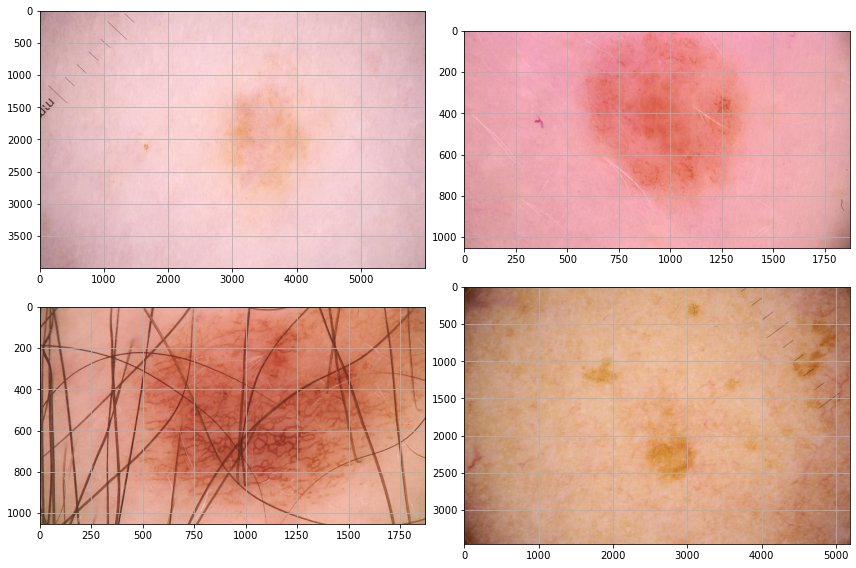

In [14]:
plt.figure(figsize = (12, 8))
for i in range(4) : 
    plt.subplot(2, 2, i + 1) 
    image = cv2.imread(os.path.join(train_dir, random_images[i]))
    # cv2 reads images in BGR format. Hence we convert it to RGB
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    sample_images.append(image)
    plt.imshow(image, cmap = "gray")
    plt.grid(True)
# Automatically adjust subplot parameters to give specified padding.
plt.tight_layout()

## OpenCV implementation of the aforementioned approach :
cv2.fastNlMeansDenoisingColored() - Works on Colored images cv2.fastNlMeansDenoising() - Works on graysacle images

Common arguments are:

* h : parameter deciding filter strength. Higher h value removes noise better, but removes details of image also. (10 is ok)
* hForColorComponents : same as h, but for color images only. (normally same as h)
* templateWindowSize : should be odd. (recommended 7)
* searchWindowSize : should be odd. (recommended 21)

In [15]:
def non_local_means_denoising(image) : 
    denoised_image = cv2.fastNlMeansDenoisingColored(image, None, 10, 10, 7, 21)
    return denoised_image

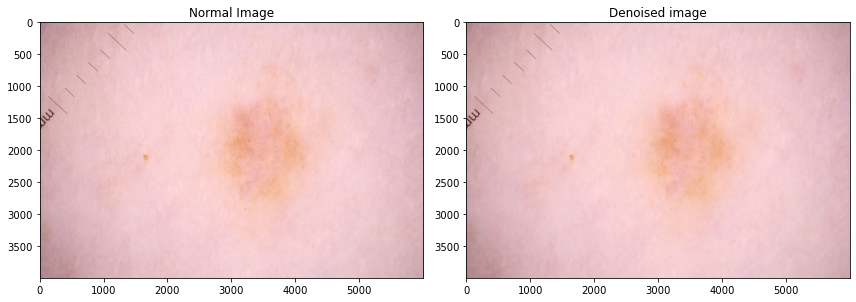

In [16]:
sample_image = cv2.imread(os.path.join(train_dir, random_images[0]))
# cv2 reads images in BGR format. Hence we convert it to RGB
sample_image = cv2.cvtColor(sample_image, cv2.COLOR_BGR2RGB)
denoised_image = non_local_means_denoising(sample_image)


plt.figure(figsize = (12, 8))
plt.subplot(1,2,1)
plt.imshow(sample_image, cmap = "gray")
plt.grid(False)
plt.title("Normal Image")

plt.subplot(1,2,2)  
plt.imshow(denoised_image, cmap = "gray")
plt.grid(False)
plt.title("Denoised image")    
# Automatically adjust subplot parameters to give specified padding.
plt.tight_layout() 

In [17]:
def histogram_equalization(image) : 
    image_ycrcb = cv2.cvtColor(image, cv2.COLOR_RGB2YCR_CB)
    y_channel = image_ycrcb[:,:,0] # apply local histogram processing on this channel
    cr_channel = image_ycrcb[:,:,1]
    cb_channel = image_ycrcb[:,:,2]
    
    # Local histogram equalization
    clahe = cv2.createCLAHE(clipLimit = 2.0, tileGridSize=(8,8))
    equalized = clahe.apply(y_channel)
    equalized_image = cv2.merge([equalized, cr_channel, cb_channel])
    equalized_image = cv2.cvtColor(equalized_image, cv2.COLOR_YCR_CB2RGB)
    return equalized_image

In [18]:
equalized_image = histogram_equalization(denoised_image)

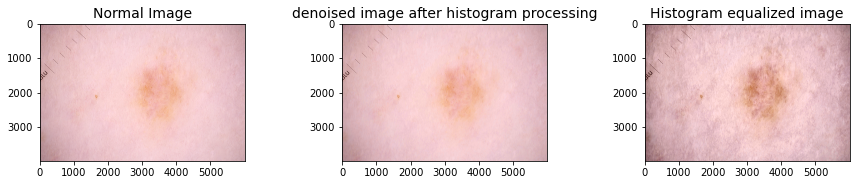

In [19]:
plt.figure(figsize = (12, 8))
plt.subplot(1,3,1)
plt.imshow(sample_image, cmap = "gray")
plt.grid(False)
plt.title("Normal Image", fontsize = 14)

plt.subplot(1,3,2)  
plt.imshow(denoised_image, cmap = "gray")
plt.grid(False)
plt.title("denoised image after histogram processing", fontsize = 14)

plt.subplot(1,3,3)  
plt.imshow(equalized_image, cmap = "gray")
plt.grid(False)
plt.title("Histogram equalized image", fontsize = 14)
# Automatically adjust subplot parameters to give specified padding.
plt.tight_layout()

In [20]:
def segmentation(image, k, attempts) : 
    vectorized = np.float32(image.reshape((-1, 3)))
    criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 20, 1.0)
    res , label , center = cv2.kmeans(vectorized, k, None, criteria, attempts, cv2.KMEANS_PP_CENTERS)
    center = np.uint8(center)
    res = center[label.flatten()]
    segmented_image = res.reshape((image.shape))
    return segmented_image

Text(0.5, 1.0, 'de Noised Image')

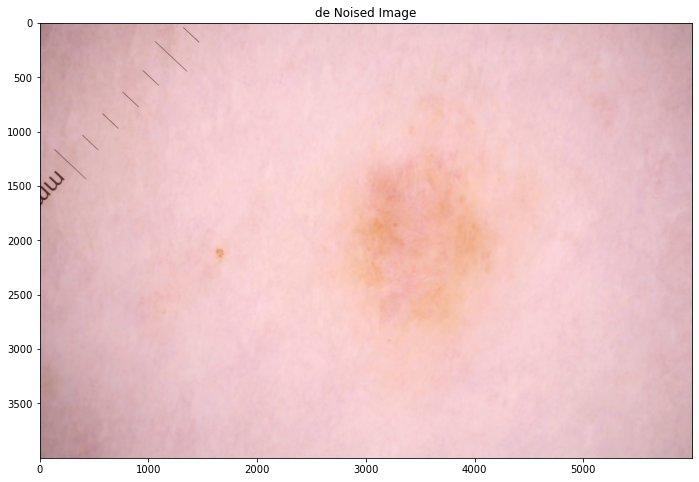

In [21]:
plt.figure(figsize = (12, 8))
plt.subplot(1,1,1)
plt.imshow(denoised_image, cmap = "gray")
plt.grid(False)
plt.title("de Noised Image")

Text(0.5, 1.0, 'Segmented Image with k = 5')

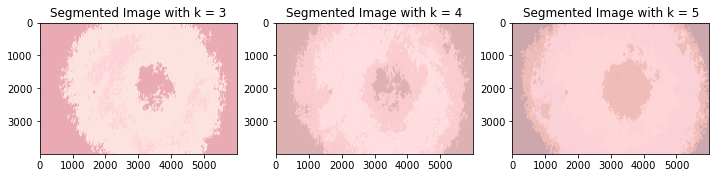

In [22]:
plt.figure(figsize = (12, 8))
segmented_image = segmentation(denoised_image, 3, 10) # k = 3, attempt = 10
plt.subplot(1,3,1)
plt.imshow(segmented_image, cmap = "gray")
plt.grid(False)
plt.title("Segmented Image with k = 3")

segmented_image = segmentation(denoised_image, 4, 10) # k = 4, attempt = 10
plt.subplot(1,3,2)
plt.imshow(segmented_image, cmap = "gray")
plt.grid(False)
plt.title("Segmented Image with k = 4")

segmented_image = segmentation(denoised_image, 5, 10) # k = 5, attempt = 10
plt.subplot(1,3,3)
plt.imshow(segmented_image, cmap = "gray")
plt.grid(False)
plt.title("Segmented Image with k = 5")

In [23]:
from sklearn.model_selection import train_test_split 
training_files, validation_files = train_test_split(tf.io.gfile.glob(GCS_PATH + "/tfrecords/train*.tfrec"),
                                                   test_size = 0.1, random_state = 42)

testing_files = tf.io.gfile.glob(GCS_PATH + "/tfrecords/test*.tfrec")

print("Number of training files = ", len(training_files))
print("Number of validation files = ", len(validation_files))
print("Number of test files = ", len(testing_files))

Number of training files =  14
Number of validation files =  2
Number of test files =  16


In [24]:
def decode_image(image) : 
    image = tf.image.decode_jpeg(image, channels = 3)
    image = tf.cast(image, tf.float32)
    image = image / 255.0
    image = tf.reshape(image, [IMAGE_SIZE[0], IMAGE_SIZE[1], 3])
    return image

In [25]:
sample_images[0].shape

(4000, 6000, 3)

We observe our training_files object stores all tfrecord files. Let's pick one to analyze. 

In [26]:
training_files

['gs://kds-0239565729562a730c95deb52d5a97593f6f7b73d0d8125d1ae74f7e/tfrecords/train05-2071.tfrec',
 'gs://kds-0239565729562a730c95deb52d5a97593f6f7b73d0d8125d1ae74f7e/tfrecords/train14-2071.tfrec',
 'gs://kds-0239565729562a730c95deb52d5a97593f6f7b73d0d8125d1ae74f7e/tfrecords/train13-2071.tfrec',
 'gs://kds-0239565729562a730c95deb52d5a97593f6f7b73d0d8125d1ae74f7e/tfrecords/train11-2071.tfrec',
 'gs://kds-0239565729562a730c95deb52d5a97593f6f7b73d0d8125d1ae74f7e/tfrecords/train08-2071.tfrec',
 'gs://kds-0239565729562a730c95deb52d5a97593f6f7b73d0d8125d1ae74f7e/tfrecords/train09-2071.tfrec',
 'gs://kds-0239565729562a730c95deb52d5a97593f6f7b73d0d8125d1ae74f7e/tfrecords/train02-2071.tfrec',
 'gs://kds-0239565729562a730c95deb52d5a97593f6f7b73d0d8125d1ae74f7e/tfrecords/train15-2061.tfrec',
 'gs://kds-0239565729562a730c95deb52d5a97593f6f7b73d0d8125d1ae74f7e/tfrecords/train04-2071.tfrec',
 'gs://kds-0239565729562a730c95deb52d5a97593f6f7b73d0d8125d1ae74f7e/tfrecords/train07-2071.tfrec',
 'gs://kds

In [27]:
sample_picked = training_files[0]
sample_picked

'gs://kds-0239565729562a730c95deb52d5a97593f6f7b73d0d8125d1ae74f7e/tfrecords/train05-2071.tfrec'

A TFRecord file can be read using **tf.data.TFRecordDataset** class.

In [28]:
file = tf.data.TFRecordDataset(sample_picked)
file

<TFRecordDatasetV2 shapes: (), types: tf.string>

In [29]:
feature_description = {"image" : tf.io.FixedLenFeature([], tf.string), 
                      "target" : tf.io.FixedLenFeature([], tf.int64)}

In [30]:
def parse_function(example) : 
    # The example supplied is parsed based on the feature_description above.
    return tf.io.parse_single_example(example, feature_description)

In [31]:
parsed_dataset = file.map(parse_function)
parsed_dataset

<MapDataset shapes: {image: (), target: ()}, types: {image: tf.string, target: tf.int64}>

In [32]:
def read_tfrecord(example, labeled) : 
    if labeled == True : 
        tfrecord_format = {"image" : tf.io.FixedLenFeature([], tf.string),
                           "target" : tf.io.FixedLenFeature([], tf.int64)}
    else:
        tfrecord_format = {"image" : tf.io.FixedLenFeature([], tf.string),
                          "image_name" : tf.io.FixedLenFeature([], tf.string)}
    
    example = tf.io.parse_single_example(example, tfrecord_format)
    image = decode_image(example["image"])
    if labeled == True : 
        label = tf.cast(example["target"], tf.int32)
        return image, label
    else:
        image_name = example["image_name"]
        return image, image_name     

In [33]:
def load_dataset(filenames, labeled, ordered):
    ignore_order = tf.data.Options()
    if ordered == False: # dataset is unordered, so we ignore the order to load data quickly.
        ignore_order.experimental_deterministic = False # This disables the order and enhances the speed
    dataset = tf.data.TFRecordDataset(filenames, num_parallel_reads=AUTOTUNE) 
    dataset = dataset.with_options(ignore_order) 
    dataset = dataset.map(partial(read_tfrecord, labeled=labeled), num_parallel_calls=AUTOTUNE)
    return dataset

In [34]:
def image_augmentation(image, label) :     
    image = tf.image.resize(image, SHAPE)
    image = tf.image.random_flip_left_right(image)
    return image, label

# Load The Datasets : 

In [35]:
def get_training_dataset() : 
    dataset = load_dataset(training_files, labeled = True, ordered = False)
    dataset = dataset.map(image_augmentation, num_parallel_calls=AUTOTUNE)
    dataset = dataset.repeat()
    dataset = dataset.batch(BATCH_SIZE)
    dataset = dataset.prefetch(AUTOTUNE) 
    return dataset

In [36]:
def get_validation_dataset() : 
    dataset = load_dataset(validation_files, labeled = True, ordered = False)
    dataset = dataset.map(image_augmentation, num_parallel_calls=AUTOTUNE)
    dataset = dataset.batch(BATCH_SIZE)
    dataset = dataset.cache()
    dataset = dataset.prefetch(AUTOTUNE) 
    return dataset

In [37]:
def get_test_dataset() : 
    dataset = load_dataset(testing_files, labeled = False, ordered = True)
    dataset = dataset.map(image_augmentation, num_parallel_calls=AUTOTUNE)
    dataset = dataset.batch(BATCH_SIZE)
    dataset = dataset.cache()
    dataset = dataset.prefetch(AUTOTUNE) 
    return dataset

In [38]:
training_dataset = get_training_dataset()

In [39]:
validation_dataset = get_validation_dataset()

In [40]:
def count_data_items(filenames):
    n = [int(re.compile(r"-([0-9]*)\.").search(filename).group(1)) for filename in filenames]
    return np.sum(n)

num_training_images = count_data_items(training_files)
num_validation_images = count_data_items(validation_files)
num_testing_images = count_data_items(testing_files)

STEPS_PER_EPOCH_TRAIN = num_training_images // BATCH_SIZE
STEPS_PER_EPOCH_VAL = num_validation_images // BATCH_SIZE

print("Number of Training Images = ", num_training_images)
print("Number of Validation Images = ", num_validation_images)
print("Number of Testing Images = ", num_testing_images)
print("\n")
print("Numer of steps per epoch in Train = ", STEPS_PER_EPOCH_TRAIN)
print("Numer of steps per epoch in Validation = ", STEPS_PER_EPOCH_VAL)

Number of Training Images =  28984
Number of Validation Images =  4142
Number of Testing Images =  10982


Numer of steps per epoch in Train =  226
Numer of steps per epoch in Validation =  32


In [41]:
image_batch, label_batch = next(iter(training_dataset))

In [42]:
def show_batch(image_batch, label_batch) :
    plt.figure(figsize = (20, 20))
    for n in range(8) : 
        ax = plt.subplot(2,4,n+1)
        plt.imshow(image_batch[n])
        if label_batch[n] == 0 : 
            plt.title("BENIGN")
        else:
            plt.title("MALIGNANT")
    plt.grid(False)
    plt.tight_layout()       

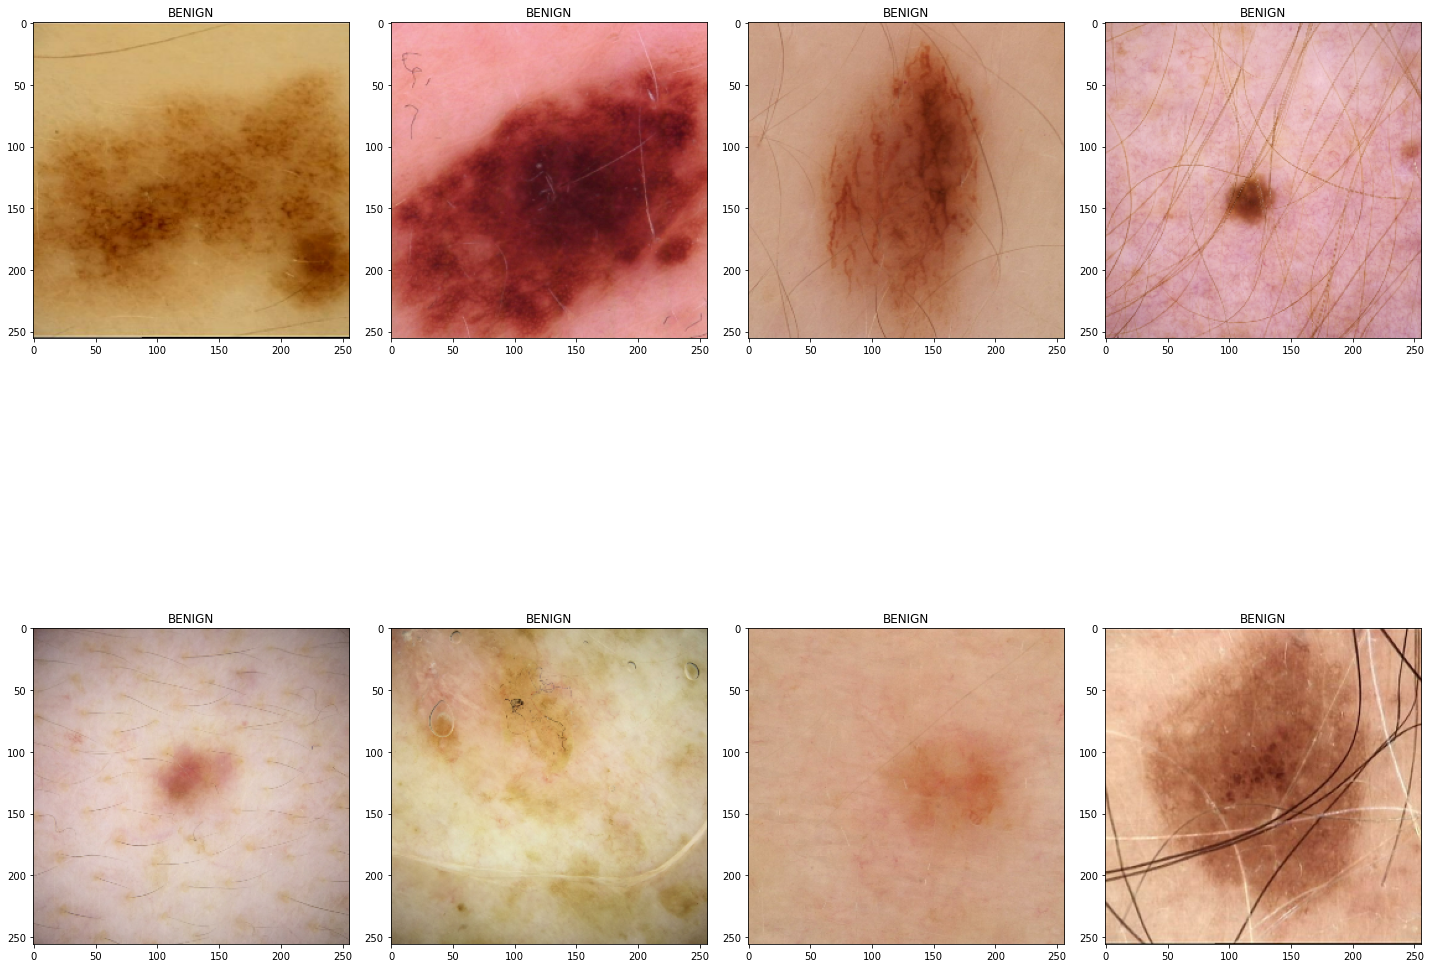

In [43]:
show_batch(image_batch.numpy(), label_batch.numpy())

Let's free up some memory

In [44]:
del image_batch
del label_batch
gc.collect()

17687

# Model Construction : 

## Malignant VS Benign Imbalance Analysis 

In [45]:
malignant = len(train[train["target"] == 1])
benign = len(train[train["target"] == 0 ])
total = len(train) 

print("Malignant Cases in Train Data = ", malignant)
print("Benign Cases In Train Dataset = ",benign)
print("Total Cases In Train Dataset = ",total)
print("Ratio of Malignant to Benign = ",malignant/benign)

Malignant Cases in Train Data =  584
Benign Cases In Train Dataset =  32542
Total Cases In Train Dataset =  33126
Ratio of Malignant to Benign =  0.017946038965029807


In [46]:
weight_malignant = (total/malignant)/2.0
weight_benign = (total/benign)/2.0

class_weight = {0 : weight_benign , 1 : weight_malignant}

print("Weight for benign cases = ", class_weight[0])
print("Weight for malignant cases = ", class_weight[1])

Weight for benign cases =  0.5089730194825149
Weight for malignant cases =  28.361301369863014


In [47]:
callback_early_stopping = tf.keras.callbacks.EarlyStopping(patience = 15, verbose = 0, restore_best_weights = True)

callbacks_lr_reduce = tf.keras.callbacks.ReduceLROnPlateau(monitor = "val_auc", factor = 0.1, patience = 10, 
                                                          verbose = 0, min_lr = 1e-6)

callback_checkpoint = tf.keras.callbacks.ModelCheckpoint("melanoma_weights.h5",
                                                         save_weights_only=True, monitor='val_auc',
                                                         mode='max', save_best_only = True)

In [48]:
with strategy.scope() : 
    bias = np.log(malignant/benign)
    bias = tf.keras.initializers.Constant(bias)
    base_model = tf.keras.applications.ResNet50(input_shape = (SHAPE[0], SHAPE[1], 3), include_top = False,
                                               weights = "imagenet")
    base_model.trainable = False
    model = tf.keras.Sequential([base_model,
                                 tf.keras.layers.GlobalAveragePooling2D(),
                                 tf.keras.layers.Dense(20, activation = "relu"),
                                 tf.keras.layers.Dropout(0.4),
                                 tf.keras.layers.Dense(10, activation = "relu"),
                                 tf.keras.layers.Dropout(0.3),
                                 tf.keras.layers.Dense(1, activation = "sigmoid", bias_initializer = bias)                                     
                                ])
    model.compile(optimizer = tf.keras.optimizers.Adam(lr = 1e-2), loss = "binary_crossentropy", metrics = [tf.keras.metrics.AUC(name = 'auc')])
    model.summary()
    
    EPOCHS = 500
    history = model.fit(training_dataset, epochs = EPOCHS, steps_per_epoch = STEPS_PER_EPOCH_TRAIN,
                       validation_data = validation_dataset, validation_steps = STEPS_PER_EPOCH_VAL,
                       callbacks = [callback_early_stopping, callbacks_lr_reduce, callback_checkpoint],
                       class_weight = class_weight)

94773248/94765736 [==============================] - 2s 0us/step
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet50 (Model)             (None, 8, 8, 2048)        23587712  
_________________________________________________________________
global_average_pooling2d (Gl (None, 2048)              0         
_________________________________________________________________
dense (Dense)                (None, 20)                40980     
_________________________________________________________________
dropout (Dropout)            (None, 20)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 10)                210       
_________________________________________________________________
dropout_1 (Dropout)          (None, 10)                0         
_________________________________________________________

In [49]:
n_epochs_it_ran_for = len(history.history['loss'])
n_epochs_it_ran_for

16

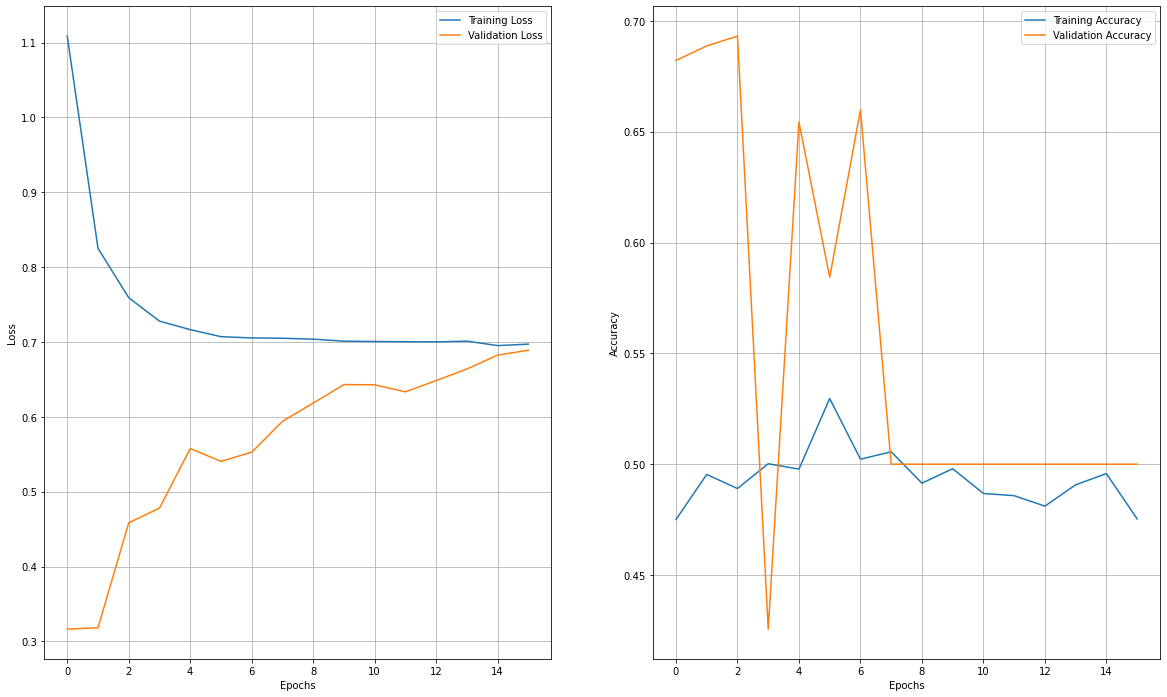

In [50]:
X = np.arange(0,n_epochs_it_ran_for,1)
plt.figure(1, figsize = (20, 12))
plt.subplot(1,2,1)
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.plot(X, history.history["loss"], label = "Training Loss")
plt.plot(X, history.history["val_loss"], label = "Validation Loss")
plt.grid(True)
plt.legend()

plt.subplot(1,2,2)
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.plot(X, history.history["auc"], label = "Training Accuracy")
plt.plot(X, history.history["val_auc"], label = "Validation Accuracy")
plt.grid(True)
plt.legend()

Due to callbacks, best weights are automatically restored!

In [51]:
testing_dataset = get_test_dataset()
testing_dataset_images = testing_dataset.map(lambda image, image_name : image)
testing_image_names = testing_dataset.map(lambda image, image_name : image_name)

In [52]:
resulting_probabilities = model.predict(testing_dataset_images, verbose = 1)

86/86 [==============================] - 13s 157ms/step


In [53]:
len(resulting_probabilities)

10982

In [54]:
sample_submission_file = pd.read_csv("../input/siim-isic-melanoma-classification/sample_submission.csv")
sample_submission_file.head()

,image_name,target
0,ISIC_0052060,0
1,ISIC_0052349,0
2,ISIC_0058510,0
3,ISIC_0073313,0
4,ISIC_0073502,0


In [55]:
del sample_submission_file["target"]
sample_submission_file.head()

,image_name
0,ISIC_0052060
1,ISIC_0052349
2,ISIC_0058510
3,ISIC_0073313
4,ISIC_0073502


In [56]:
testing_image_names

<MapDataset shapes: (None,), types: tf.string>

In [57]:
testing_image_names = np.concatenate([x for x in testing_image_names], axis=0)
testing_image_names = np.array(testing_image_names)

In [58]:
decoded_test_names = []
for names in testing_image_names : 
    names = names.decode('utf-8')
    decoded_test_names.append(names)
decoded_test_names = np.array(decoded_test_names)
del testing_image_names

In [59]:
len(decoded_test_names), type(decoded_test_names), decoded_test_names.shape

(10982, numpy.ndarray, (10982,))

In [60]:
decoded_test_names

array(['ISIC_6381819', 'ISIC_5583376', 'ISIC_6408546', ...,
       'ISIC_8285611', 'ISIC_2076526', 'ISIC_8959686'], dtype='<U12')

In [61]:
testing_image_names = pd.DataFrame(decoded_test_names, columns=["image_name"])
testing_image_names.head()

,image_name
0,ISIC_6381819
1,ISIC_5583376
2,ISIC_6408546
3,ISIC_6932354
4,ISIC_8191278


In [62]:
pred_dataframe = pd.DataFrame({"image_name" : decoded_test_names, 
                               "target" : np.concatenate(resulting_probabilities)})
pred_dataframe

,image_name,target
0,ISIC_6381819,0.257579
1,ISIC_5583376,0.257815
2,ISIC_6408546,0.261699
3,ISIC_6932354,0.262579
4,ISIC_8191278,0.264659
...,...,...
10977,ISIC_1581247,0.257579
10978,ISIC_8432732,0.274642
10979,ISIC_8285611,0.269494
10980,ISIC_2076526,0.256005


In [63]:
sample_submission_file = sample_submission_file.merge(pred_dataframe, on = "image_name")
sample_submission_file.to_csv("submission.csv", index = False)
sample_submission_file.head()

,image_name,target
0,ISIC_0052060,0.257418
1,ISIC_0052349,0.261699
2,ISIC_0058510,0.267157
3,ISIC_0073313,0.257579
4,ISIC_0073502,0.256005
